<a href="https://colab.research.google.com/github/LarsAmker/ExplainGAN/blob/master/Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and access the data

In [0]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [0]:
#!pwd
!mkdir ~/.kaggle
#!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

### Upload the kaggle.json file manually in the left hand pane

This is needed to get the data directly from kaggle

In [0]:
# copy the json file into the kaggle directory
!cp kaggle.json ~/.kaggle/

In [0]:
# Download pneumonia data (first line makes kaggle API key unreadable)
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
# the zip file is listed in the left hand pane after the download. We need to unzip and create paths

In [0]:
!unzip chest-xray-pneumonia.zip

In [0]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
color = sns.color_palette()
%matplotlib inline

# added tensorflow:
import tensorflow as tf

In [7]:
# My directory is called "content" instead of "input" as in the original code
#os.listdir("../content/chest_xray/chest_xray") 

['val', 'test', 'train', '.DS_Store']

## Make the data accessible

NAIN had a code box fixing some random seeds here. Not compatible with tf2 however, therefore deleted and saved in testPneumonia/reproducability

The dataset is divided into three sets: 1) train set 2) validation set and 3) test set. Let's grab the dataset

In [0]:
# Define path to the data directory: "content" instead of "input/chest-xray-pneumonia" as in the original code
data_dir = Path('../content/chest_xray/chest_xray')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

Each of the above directories contains two sub-directories:

NORMAL: These are the samples that describe the normal (no pneumonia) case.

PNEUMONIA: This directory contains those samples that are the pneumonia cases.

### Training data

In [0]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
#train_data.head()

### Validation data
We will be defining a generator for the training dataset later in the notebook but as the validation data is small, so I can read the images and can load the data without the need of a generator. This is exactly what the code block given below is doing.

In [10]:
# Why do we make artificial RGB pictures? Because the weights from imageNet that we import are for RGB pictures
# Get the path to the sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []

# Some images are in grayscale while majority of them contains 3 channels. 
# So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img]) # add a third dimension for RGB channels and fill it with 3 copies of the original
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (16, 224, 224, 3)
Total number of labels: (16, 2)


### Test data

In [11]:
# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 224, 224, 3)
Total number of labels: (624, 2)


### Training data generator (stop ExplainGAN preprocessing before this?)
Data augmentation is a powerful technique which helps in almost every case for improving the robustness of a model. But augmentation can be much more helpful where the dataset is imbalanced. You can generate different samples of undersampled class in order to try to balance the overall distribution.
I like imgaug a lot. It comes with a very clean api and you can do hell of augmentations with it. It's worth exploring!! In the next code block, I will define a augmentation sequence. You will notice Oneof and it does exactly that. At each iteration, it will take one augmentation technique out of the three and will apply that on the samples

In [0]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [0]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

# Classifier (NAIN's depthwise kernel)

Build and compile an empty model and then load the weights for it from my google drive. These weights were created and saved in the notebook "PneumoniaClassifier.ipynb"

In [0]:
# changed the format of this method due to compatibility with tensorflow 2
# The original version from NAIN worked with "x=...(x)" steps, my theory is that this x is the placeholder that lead to errors
from tensorflow.keras import layers

def build_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv1_1', input_shape=[224, 224, 3]))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv1_2', input_shape=[224, 224, 3]))
  model.add(layers.MaxPooling2D((2,2), name='pool'))

  model.add(layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1'))
  model.add(layers.SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2'))
  model.add(layers.MaxPooling2D((2,2), name='pool2'))

  model.add(layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1'))
  model.add(layers.BatchNormalization(name='bn1'))
  model.add(layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2'))
  model.add(layers.BatchNormalization(name='bn2'))
  model.add(layers.SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3'))
  model.add(layers.MaxPooling2D((2,2), name='pool3'))

  model.add(layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1'))
  model.add(layers.BatchNormalization(name='bn3'))
  model.add(layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2'))
  model.add(layers.BatchNormalization(name='bn4'))
  model.add(layers.SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3'))
  model.add(layers.MaxPooling2D((2,2), name='pool4'))

  model.add(layers.Flatten(name='flatten'))
  model.add(layers.Dense(1024, activation='relu', name='fc1'))
  model.add(layers.Dropout(0.7, name='dropout1'))
  model.add(layers.Dense(512, activation='relu', name='fc2'))
  model.add(layers.Dropout(0.5, name='dropout2'))
  model.add(layers.Dense(2, activation='softmax', name='fc3'))
  
  return model

In [0]:
model =  build_model()
#model.summary()

In [0]:
# opt = RMSprop(lr=0.0001, decay=1e-6)
opt = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [18]:
model.load_weights('/content/gdrive/My Drive/Colab Notebooks/DepthwiseWeights')

### Testing classifier

In [19]:
# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

39/39 [==============================] - 2s 63ms/step - loss: 1.4144 - accuracy: 0.7965
Loss on test set:  1.4144045114517212
Accuracy on test set:  0.7964743375778198


In [20]:
# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(624,)
(624,)


<Figure size 432x288 with 0 Axes>

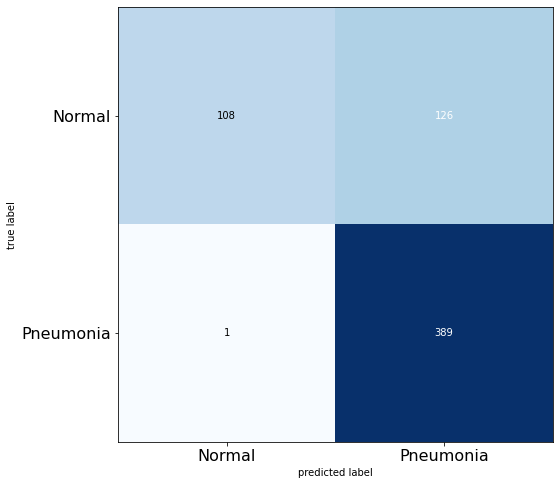

In [21]:
# Get the confusion matrix
cm = confusion_matrix(orig_test_labels, preds)
plt.figure()
#plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, alpha=0.7,cmap=plt.cm.Blues)
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [22]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 1.00
Precision of the model is 0.76


# ExplainGAN

In [35]:
print(train_data.shape) # this is a data frame of paths to the images and their labels.
# The train data generator gets the images from the paths. This saves memory compared to saving all training images
print(valid_data.shape)
print(test_data.shape)

(5216, 2)
(16, 224, 224, 3)
(624, 224, 224, 3)
